In [1]:
import wandb
from datetime import datetime

In [1]:
batch_size = 1
lr = 1e-3
wd = 1e-5

In [ ]:
wandb_entity='longyi'
model_name = "resnet50"
wandb.init(project="cervical-spine", entity=wandb_entity, config={
    "model":model_name,
    "batch_size":batch_size,
    "lr" : lr,
    "wd" : wd
})
wandb.run.name = f'xray_{model_name}_' + datetime.now().strftime("%H%M%S")

In [2]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from tqdm import tqdm

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from utils.dcm_utils import *
from utils.nii_utils import *
from utils.train_utils import *

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF

In [4]:
from models.backbone import resnet18_gray

In [5]:
DATA_DIR = "/media/longyi/SSD9701/"
TRAIN_XRAY_DIR = os.path.join(DATA_DIR, "xray_images")
TRAIN_IMAGE_DIR = os.path.join(DATA_DIR, "train_images")

In [6]:
df = pd.read_csv(os.path.join(DATA_DIR, 'meta_segmentation.csv')).set_index('id')
df.head()

,PatientID,slice_number,C1,C2,C3,C4,C5,C6,C7,min_row,max_row,min_column,max_column,width,height,width_mm,height_mm
id,,,,,,,,,,,,,,,,,
7800001,780,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
7800002,780,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
7800003,780,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
7800004,780,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
7800005,780,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0


### Dataset

In [7]:
class XraySpineDataset(Dataset):
    def __init__(self, xray_dir, label_df, transform=None, target_transform=None):
        self.xray_dir = xray_dir
        self.patient_dict = self.group_by_patient(label_df)
        self.patient_ids = list(self.patient_dict.keys())

        self.transform = transform
        self.target_transform = target_transform

    def group_by_patient(self, label_df):
        df = label_df.sort_index()
        patient_id = None
        patient_label = None
        patient_dict = {}

        len_df = len(df)
        for i in tqdm(range(len_df)):
            row = df.iloc[i]
            PatientID = int(row["PatientID"])
            if patient_id != PatientID:
                if patient_label is not None:
                    patient_dict[patient_id] = np.stack(patient_label)
                patient_id = PatientID
                patient_label = []
            patient_label.append(row[['C1','C2','C3','C4','C5','C6','C7']].values)

            if (i + 1) == len_df:
                patient_dict[patient_id] = np.stack(patient_label)
        return patient_dict

    def __len__(self):
        return len(self.patient_ids)


    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        UID = "1.2.826.0.1.3680043." + str(patient_id)

        # axial = read_image(os.path.join(self.xray_dir, UID, 'axial.jpeg')).float()
        sagittal = read_image(os.path.join(self.xray_dir, UID, 'sagittal.jpeg')).float()
        coronal = read_image(os.path.join(self.xray_dir, UID, 'coronal.jpeg')).float()

        label = self.patient_dict[patient_id]

        if self.transform:
            # axial = self.transform(axial)
            sagittal = self.transform(sagittal)
            coronal = self.transform(coronal)


        if self.target_transform:
            label = self.target_transform(label)

        return (sagittal, coronal), label


In [31]:
transform = Compose([
    T.RandomAutocontrast(0.5),
    Normalize(255 * 0.5, 255 * 0.5),
])
target_transform = Compose([
    ToTensor(),
])
dataset = XraySpineDataset(TRAIN_XRAY_DIR, df, transform=transform, target_transform=target_transform)
len(dataset)

100%|██████████| 29832/29832 [00:06<00:00, 4377.67it/s]


87

In [9]:
def print_list_shapes(list):
    for item in list:
        print(item.shape)

In [11]:
class XrayFeatureExtractModel(nn.Module):
    def __init__(self, backbone, channels, deep=4, out_channels=64, n_features=7):
        super().__init__()

        self.backbone = backbone
        self.deep = deep
        self.channels = channels
        self.out_channels = out_channels
        self.n_features = n_features

        self.init_layers()

    def init_layers(self):
        self.parallel_modules = self.make_parallel_modules()
        self.upsampling_modules = self.make_upsampling_modules()

        self.downsampling_modules = self.make_downsampling_modules()
        self.classification_modules = self.make_classification_modules()

    def make_classification_modules(self):
        # the last layer
        return nn.Sequential(
            nn.Conv2d(self.out_channels, self.n_features, kernel_size=1),
            nn.AdaptiveMaxPool2d(output_size=(None, 1))
        )

    def make_parallel_modules(self):
        parallel_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Conv2d(self.channels[i], self.channels[i], kernel_size=3, padding='same')
            parallel_modules.append(module)


        return parallel_modules

    def make_downsampling_modules(self):
        return nn.ModuleList([
            nn.Sequential(
                self.backbone.conv1,
                self.backbone.bn1,
                self.backbone.relu,
                self.backbone.maxpool),
            nn.Sequential(
                self.backbone.layer1,
                self.backbone.layer2,
            ),

            self.backbone.layer3,
            self.backbone.layer4
        ])

    def make_upsampling_modules(self):
        upsampling_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i], self.channels[i-1] if i > 0 else self.out_channels, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Upsample(scale_factor=2)
            )
            upsampling_modules.append(module)

        return upsampling_modules



    def forward(self, x):

        downsampling_outputs = []
        out = x
        for module in self.downsampling_modules:
            out = module(out)
            downsampling_outputs.append(out)

        parallel_outputs = []
        for i in range(len(self.parallel_modules)):
            module = self.parallel_modules[i]
            out = module(downsampling_outputs[i])
            parallel_outputs.append(out)

        out = 0
        for i in range(len(self.upsampling_modules)):
            module = self.upsampling_modules[-(i+1)]
            parallel_output = parallel_outputs[-(i+1)]

            up_input = out + parallel_output
            out = module(up_input)

        out = self.classification_modules(out)

        return out


# feature_module = XrayFeatureExtractModel(backbone, channels=[64, 128, 256, 512], out_channels=64, n_features=64)
# # print(model)
# input = torch.randn(1, 1, 618, 512)
# height = int(np.ceil(input.shape[2] / 16) * 16)
# print(height)
# input = TF.pad(input, (0, int(np.ceil((height - input.shape[2]) / 2)), 0, (height - input.shape[2]) // 2))
# print(input.shape)
# out = feature_module(input)
# out.shape

In [12]:
class XrayClassificationModel(nn.Module):
    def __init__(self, feature_module, in_channels, n_labels=7):
        super().__init__()

        self.feature_module = feature_module
        self.n_labels = n_labels

        self.classification_module = nn.Sequential(
            nn.Conv1d(in_channels * 2, in_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels, n_labels, kernel_size=1)
        )

    def forward(self, x):

        feature = self.feature_module(x)    # 2 x C x H x 1
        # print(feature.shape)
        feature = feature.reshape(1, -1, feature.shape[2])

        out = self.classification_module(feature)
        return out

# model = XrayClassificationModel(feature_module, 64, n_labels=7)
# input = torch.randn(2, 1, 624, 512)
# out = model(input)
# out.shape

In [13]:
def pad_dataset(x, y, deep=4):
    unit = np.power(2, deep)
    height = int(np.ceil(x.shape[2] / unit) * unit)
    left, top, right, bottom = 0, int(np.ceil((height - x.shape[2]) / 2)), 0, (height - x.shape[2]) // 2
    x = TF.pad(x, [left, top, right, bottom])
    y = F.pad(y, (top, bottom)) if y is not None else None

    return x, y

## Train

In [14]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, pin_memory=True)

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [38]:
def test_sample(model, xray_dir, transform=None, UID="1.2.826.0.1.3680043.3882"):
    model.eval()
    # axial = read_image(os.path.join(xray_dir, UID, 'axial.jpeg')).float()
    sagittal = read_image(os.path.join(xray_dir, UID, 'sagittal.jpeg')).float()
    coronal = read_image(os.path.join(xray_dir, UID, 'coronal.jpeg')).float()

    if transform:
        # axial = transform(axial)
        sagittal = transform(sagittal)
        coronal = transform(coronal)

    x = torch.stack((sagittal, coronal), dim=0).to(device)
    x, _ = pad_dataset(x, None, 4)

    logits = model(x)

    pred = torch.sigmoid(logits).float()

    pred = pred.detach().squeeze().t().cpu().numpy()
    plt.imshow(pred, aspect=0.01)
    plt.show()

# test_sample(model, TRAIN_XRAY_DIR)

In [79]:
backbone = resnet18_gray()
for param in backbone.parameters():
    param.requires_grad = False

feature_module = XrayFeatureExtractModel(backbone, channels=[64, 128, 256, 512], out_channels=64, n_features=64)
model = XrayClassificationModel(feature_module, 64, n_labels=7)
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr * 0.1, weight_decay=wd)

In [24]:
def train_one_epoch(epoch, model, dataloader):
    model.train()
    train_iter = tqdm(dataloader)

    total_loss = 0
    for i, ((sagittal, coronal), y) in enumerate(train_iter):

        x = torch.cat((sagittal, coronal), dim=0).to(device)
        y = TF.resize(y, size=[x.shape[2], y.shape[-1]]).permute((0, 2, 1)).to(device)
        x, y = pad_dataset(x, y, 4)

        logits = model(x)
        loss = F.binary_cross_entropy_with_logits(logits, y, reduction='none')
        # print(loss.shape)
        portion = y.mean()
        loss = (1 - portion) * y * loss + portion * (1 - y) * loss
        loss = loss.mean()

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()

        total_loss += loss.item()
        train_iter.set_description(f"t {epoch} loss {total_loss / (i + 1):.4f}")


In [32]:
(sagittal, coronal), y = dataset[0]
y

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float64)

0.0682254249617535
0.08738406882263733
0.08150264749422582
0.0806877877824446
0.06469390826635633
0.1737902352954768
0.08180525278368173
0.0980642795793647
0.16191254436819458
0.08706029915843894


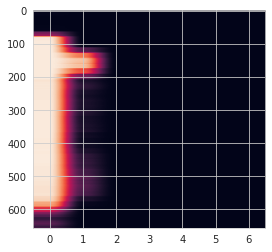

In [104]:
for i in range(10):
    (sagittal, coronal), y = dataset[i]
    x = torch.stack((sagittal, coronal)).to(device)
    y = TF.resize(y, size=[x.shape[2], y.shape[-1]]).permute((0, 2, 1)).to(device)
    x, y = pad_dataset(x, y, 4)

    logits = model(x)
    loss = F.binary_cross_entropy_with_logits(logits, y, reduction='none')
    # print(loss.shape)
    portion = y.mean()
    loss = (1 - portion) * y * loss + portion * (1 - y) * loss
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.)
    optimizer.step()

    print(loss.item())
test_sample(model, TRAIN_XRAY_DIR, UID="1.2.826.0.1.3680043.780")

t 0 loss 0.1629: 100%|██████████| 87/87 [00:05<00:00, 15.75it/s]


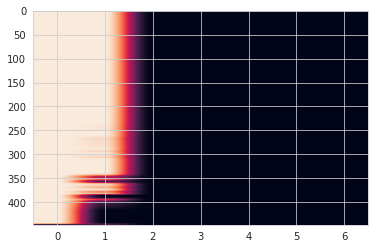

t 1 loss 0.1442: 100%|██████████| 87/87 [00:05<00:00, 15.93it/s]


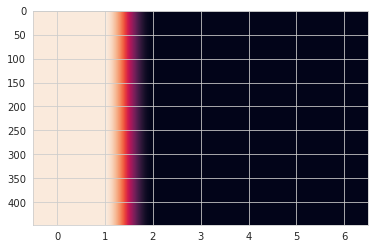

t 2 loss 0.1294: 100%|██████████| 87/87 [00:05<00:00, 15.98it/s]


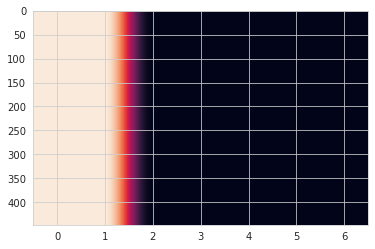

t 3 loss 0.1231: 100%|██████████| 87/87 [00:05<00:00, 15.89it/s]


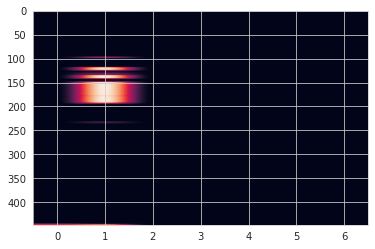

t 4 loss 0.1108: 100%|██████████| 87/87 [00:05<00:00, 15.92it/s]


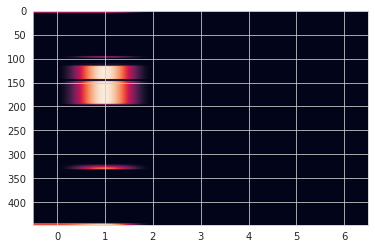

t 5 loss 0.1084: 100%|██████████| 87/87 [00:05<00:00, 16.00it/s]


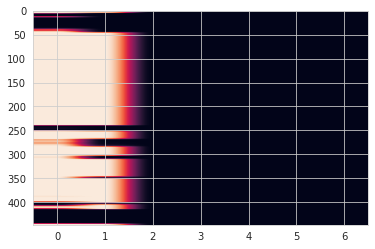

t 6 loss 0.1063: 100%|██████████| 87/87 [00:05<00:00, 16.05it/s]


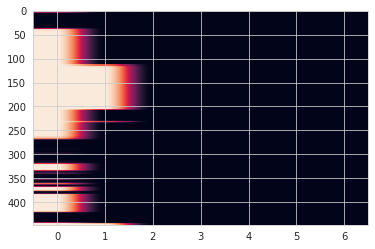

t 7 loss 0.0986: 100%|██████████| 87/87 [00:05<00:00, 16.04it/s]


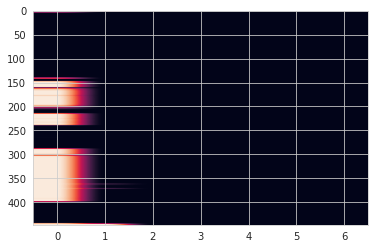

t 8 loss 0.1001: 100%|██████████| 87/87 [00:05<00:00, 16.03it/s]


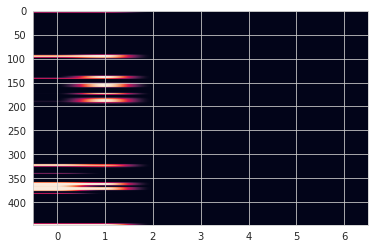

t 9 loss 0.0966: 100%|██████████| 87/87 [00:05<00:00, 16.07it/s]


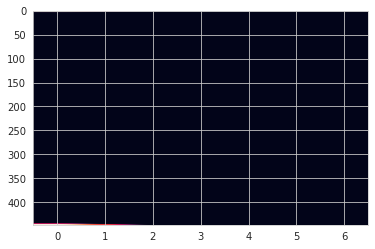

In [25]:
for epoch in range(10):
    train_one_epoch(epoch, model, dataloader)
    test_sample(model, TRAIN_XRAY_DIR)